In [1]:
import torch
import torch.nn as nn  # for neural network
import torch.nn.functional as F  # NN functions!
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

## 1. **Basic NN with torch (download MNIST dataset through internet)**

In [2]:
## transformations
transform = transforms.Compose([transforms.ToTensor()])

## Batch size for MNIST dataset
BATCH_SIZE = 32

## download training dataset
trainset = torchvision.datasets.MNIST(root = './data', train = True,
                                        download = True, transform = transform)

## load training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE,
                                          shuffle = True, num_workers = 2)

## download testing dataset
testset = torchvision.datasets.MNIST(root = './data', train = False,
                                       download = True, transform = transform)

## load testing dataset
testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE,
                                         shuffle = False, num_workers = 2)

|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729141890/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(len(trainset))

60000


In [4]:
## victorization of the 221st figure
# print(trainset[221])

## For SGD, we use multiple samples which can be choosen by
# trainset[1,2,3,4,5,6]

Classify digits task. Consider a convolutional layer followed by two fully-connected layers. 

The model is a subclass of `nn.Module` 

Modules must implement a `forward()` function which defines exactly what operations get applied to the inputted data.

Note that `MyModel` makes uses of the predefined modules `Conv2d` and `Linear`, which it instantiates in its constructor. 

Running data `x` through a module `conv1` simply consists of calling it like a function: `out = conv1(x)`.

In [5]:
class MyModel(nn.Module):  # build NN model inherites nn.Module (like a super class of NN module)
    
    def __init__(self):  # initialize function: where you define all parameters that you would like to use
                         # this is where you list all trainable parameters
        
        super(MyModel, self).__init__()  # Note: self. is important! If you want to train para in your optm step
                                         # you need write self.para_name!!!
                                         # for list, you need to write: nn.ModuleList([nn.Linear(3,3), for in in range(3)])

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)  # linear layers: (input channel, output channel) 
                                                # here, size of image:26 * 26 * 32; 32 for out_channels in CNN 
                                                # and a hidden layer with 128 nurons
        self.d2 = nn.Linear(128, 10)  # 10 for 10 classes in the task

    def forward(self, x):  # forward function: tell you how to construct the computation graph
                           # takes an imput of the actual tensor
        
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)
        # x = x.view(32, -1)  # .view() function: more efficient than the previous raw

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)  # the logits here is the 10 class score
        out = F.softmax(logits, dim = 1)
        return out

In [6]:
## brief review for numpy (using CPU)

import numpy as np
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))
# print(b)
# print(np.matmul(a,b))

## Pytorch (using GPU)

ta = torch.tensor(a, dtype = float)  # a Pytorch tensor
tb = torch.ones(2,2, dtype = float)  # a Pytorch tensor

## for GPU
# print(torch.cuba.is_avaliable())
# ta = torch.tensor(a, dtype=float).to('cuda:0')  # to(device) : which GPU you are using
# tb = torch.ones(2,2, dtype=float).to('cuda:0')

print(ta)
print(ta @ tb)  # = print(torch.matmul(ta,tb))

tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)
tensor([[3., 3.],
        [7., 7.]], dtype=torch.float64)


In [7]:
## tunning parameters for NN

learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)  # to(device): use GPU if we have one, otherwise use CPU
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  # update all parameters defined in MyModel()

Training loop: 

for each minibatch (accessed by enumerating through our data loader `trainloader`), 
we run our data through `model` in a forward pass, then compute the loss with `criterion`. 

We call `optimizer.zero_grad()` to zero out the gradients from the previous round of training, 
followed by `loss.backward()` to backpropagate the new round of gradients and 
finally `optimizer.step()` to adjust the model parameters based on these gradients.

In [8]:
for epoch in range(num_epochs):
    
    train_running_loss = 0.0
    train_acc = 0.0

    ## training step
    for i, (images, labels) in enumerate(trainloader):  # how many sample to use in every iterration
                                                        # Note: batch size has been defined in trainloader
        
        images = images.to(device)  # use GPU is available
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)  # forward
        loss = criterion(logits, labels)
        optimizer.zero_grad()  # IMPORTANT! Or Pytorch will add up all gradient
        loss.backward()  # backpropagate

        ## update model params
        optimizer.step()  # for all model.parameters() where we've already have gradients, 
                          # we want to perform one step optimization with prespecified learning rate

        train_running_loss += loss.detach().item()  # accumulating the loss
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6690 | Train Accuracy: 0.80
Epoch: 1 | Loss: 1.4947 | Train Accuracy: 0.97
Epoch: 2 | Loss: 1.4826 | Train Accuracy: 0.98
Epoch: 3 | Loss: 1.4783 | Train Accuracy: 0.98
Epoch: 4 | Loss: 1.4751 | Train Accuracy: 0.99


Check one epoch on test set 

In [9]:
test_acc = 0.0

for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten()
    print(labels)
    print(preds)
    
    l = labels.cpu().numpy()  # build in sklearn
    p1 = metrics.precision_score(preds, l, average = 'micro')
    print('precision: ', p1)
    p2 = metrics.recall_score(preds, l, average = 'micro')
    print('recall: ', p2)
    break

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
precision:  1.0
recall:  1.0


Check accuracy on the whole test set

In [10]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()  # if using GPU, convert to numpy
        
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 0.98


## 2. **GNN with torch**

First install PyTorch Geometric (for creating graph neural networks) and TensorboardX ( to visualize training progress)

Alternative frameworks/libraries:

graphNets: Google (tensorflow)
DGL: Amazon

In [11]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Using pip 21.0.1 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)
Non-user install because site-packages writeable
Created temporary directory: /tmp/pip-ephem-wheel-cache-h0zyk6nx
Created temporary directory: /tmp/pip-req-tracker-qd4lo1k4
Initialized build tracking at /tmp/pip-req-tracker-qd4lo1k4
Created build tracker: /tmp/pip-req-tracker-qd4lo1k4
Entered build tracker: /tmp/pip-req-tracker-qd4lo1k4
Created temporary directory: /tmp/pip-install-xmyegohb
1 location(s) to search for versions of torch-scatter:
* https://pypi.org/simple/torch-scatter/
Fetching project page and analyzing links: https://pypi.org/simple/torch-scatter/
Getting page https://pypi.org/simple/torch-scatter/
Found index url https://pypi.org/simple
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/torch-scatter/ HTTP/1.1" 200 1720
  Found link https://files.pythonhosted.org/packages/29/96/566ac314e796d4b07209a3b88cc7a8d2e8582d55819e33f72e6c0e8d8216/torch_scatter-0.3.0.ta

In [12]:
## set of dependences

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn  # Pytorch for geometric
import torch_geometric.utils as pyg_utils  # Pytorch for geometric

import time
from datetime import datetime

import networkx as nx  # for graph visualization, not necessary
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset  # build in datasets
from torch_geometric.datasets import Planetoid  # build in datasets
from torch_geometric.data import DataLoader  # build in datasets

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter  # for tracking learning process, visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

**Build GNN**

The `GNNStack` is general framework for a GNN which can handle different types of convolutional layers, and both node and graph classification. 

The `build_conv_model` method determines which type of convolutional layer to use for the given task:

here use a graph convolutional network for node classification, and a graph isomorphism network for graph classification. 

Note that PyTorch Geometric provides out-of-the-box modules for these layers. 

The model consists of 3 layers of convolution, followed by mean pooling in the case of graph classification, followed by two fully-connected layers. 

Since the goal here is classification, we use a negative log-likelihood loss function.

In [13]:
## node classification task

class GNNStack(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(  # similar to nn.ModuleList(), nn.Sequential() run sequentially
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':  # node classification task
            return pyg_nn.GCNConv(input_dim, hidden_dim)  # GCN: Graph Convolutional Network, just one layer!
                                                          # pyg_nn.GCNConv() can be replaced by CustomConv() if defined
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  # data.x: node feature
                                                                    # data.edge_index: if nodes i,j has link, then i j
                                                                    # batch: (which note belongs to which graph, for classification task)
                                                                    # batch of graph, hard, as networks have different sizes
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)  # sanity check: if no node feature, use all one vector

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)  # as defined: self.convs = nn.ModuleList(), every element is a convolution layer
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout, training = self.training)  # note: dropout is different btw training and testing (no dropout at testing)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)  # for fraph classification task, need pooling (mean_pool, max_pool)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim = 1)  # emb: embedding, for visualization

    def loss(self, pred, label):
        return F.nll_loss(pred, label)  # negative log likelihood

Here **pyg_nn.GCNConv** and **pyg_nn.GINConv** are instances of MessagePassing. They define a single layer of graph convolution, which can be decomposed into:
* Message computation
* Aggregation
* Update
* Pooling

**An example of how to subclass the pytorch geometric MessagePassing class to derive a new model (rather than using existing GCNConv and GINConv).**

Make use of `MessagePassing`'s key building blocks:
- `aggr='add'`: The aggregation method to use ("add", "mean" or "max").
- `propagate()`: The initial call to start propagating messages. Takes in the edge indices and any other data to pass along (e.g. to update node embeddings).
- `message()`: Constructs messages to node i. Takes any argument which was initially passed to propagate().
- `update()`: Updates node embeddings. Takes in the output of aggregation as first argument and any argument which was initially passed to propagate().


In [14]:
## make own convolution module

class CustomConv(pyg_nn.MessagePassing):
    
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation. Calling super class
        self.lin = nn.Linear(in_channels, out_channels)  # define parameters in a linear layer
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]: feature matrix
        # edge_index has shape [2, E]: Aj matrix

        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        # x = self.lin(x)

        ## return self and neighborhood information
        return self_x + self.propagate(edge_index, size = (x.size(0), x.size(0)), x = self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype = x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        
        ## Normlaization
        # F.normalize(aggr_out, p = 2, dim = -1)
        
        return aggr_out

**Train** the model in a standard way here, running it forwards to compute its predicted label distribution and backpropagating the error. 

Note the task setup : for node classification, we define a subset of nodes to be training nodes and the rest of the nodes to be test nodes, 

and mask out the test nodes during training via `batch.train_mask`. 

For graph classification, we use 80% of the graphs for training and the remainder for testing (better to also have dev set), as in other classification settings.

In [15]:
def train(dataset, task, writer):
    
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size = 64, shuffle = True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size = 64, shuffle = True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size = 64, shuffle = True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task = task)
    opt = optim.Adam(model.parameters(), lr = 0.01)
    
    # train
    for epoch in range(200):  # 200 epoches
        
        total_loss = 0
        model.train()
        
        for batch in loader:
            
            #print(batch.train_mask, '----')
            opt.zero_grad()  # SUPER IMPORTNAT
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':  # for node classification task (train on a single graph)
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]  # like CV
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)  # writer. : nice tensorbox function

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

**Test** time, for the CiteSeer/Cora node classification task, there is only 1 graph. 

Use masking to determine validation and test set.

For graph classification tasks, a subset of graphs is considered validation / test graph.

In [16]:
def test(loader, model, is_validation = False):
    
    model.eval()

    correct = 0
    for data in loader:
        
        with torch.no_grad():  # save time (when testing, do not to optmize)
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    
    return correct / total

### 2.1 Train model

First, run this snippet to generate a link to TensorBoardX, which will output a page where you can visualize the loss and accuracy curves of the model.

In [17]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format("./log")
)

get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://cdd1705c172a.ngrok.io


### ENZYMES dataset

Start training. When it's finished, you should be able to see its training and test performance over time on the TensorBoardX page. 

If you run the snippet multiple times, you will be able to see multiple training curves and compare them.

Start with a graph classification task on the IMDB-BINARY dataset.

In [18]:
## node classification task

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root = '/tmp/ENZYMES', name = 'ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!
Epoch 0. Loss: 1.8135. Test accuracy: 0.1083
Epoch 10. Loss: 1.7595. Test accuracy: 0.1917
Epoch 20. Loss: 1.7455. Test accuracy: 0.2667
Epoch 30. Loss: 1.7275. Test accuracy: 0.1917
Epoch 40. Loss: 1.7200. Test accuracy: 0.1833
Epoch 50. Loss: 1.6995. Test accuracy: 0.2083
Epoch 60. Loss: 1.7014. Test accuracy: 0.2583
Epoch 70. Loss: 1.6908. Test accuracy: 0.2667
Epoch 80. Loss: 1.7093. Test accuracy: 0.1583
Epoch 90. Loss: 1.6833. Test accuracy: 0.1750
Epoch 100. Loss: 1.6911. Test accuracy: 0.1750
Epoch 110. Loss: 1.6617. Test accuracy: 0.1667
Epoch 120. Loss: 1.6684. Test accuracy: 0.1750
Epoch 130. Loss: 1.6462. Test accuracy: 0.2750
Epoch 140. Loss: 1.6760. Test accuracy: 0.1917
Epoch 150. Loss: 1.6825. Test accuracy: 0.1583
Epoch 160. Loss: 1.6566. Test accuracy: 0.1500
Epoch 170. Loss: 1.6567. Test accuracy: 0.2000
Epoch 180. Loss: 1.6433. Test accuracy: 0.1500
Epoch 190. Loss: 1.6693. Test accuracy: 0.1667


One more example:

### Citation dataset

Node classification task on the Citeseer citation network.

In [19]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name = 'cora')
task = 'node'

model = train(dataset, task, writer)

Processing...
Done!
Epoch 0. Loss: 1.9723. Test accuracy: 0.4040
Epoch 10. Loss: 0.5657. Test accuracy: 0.7130
Epoch 20. Loss: 0.1067. Test accuracy: 0.7580
Epoch 30. Loss: 0.0357. Test accuracy: 0.7600
Epoch 40. Loss: 0.0130. Test accuracy: 0.7190
Epoch 50. Loss: 0.0332. Test accuracy: 0.7650
Epoch 60. Loss: 0.1194. Test accuracy: 0.7690
Epoch 70. Loss: 0.0267. Test accuracy: 0.7440
Epoch 80. Loss: 0.0372. Test accuracy: 0.7600
Epoch 90. Loss: 0.0012. Test accuracy: 0.7530
Epoch 100. Loss: 0.0016. Test accuracy: 0.7470
Epoch 110. Loss: 0.0056. Test accuracy: 0.7490
Epoch 120. Loss: 0.0014. Test accuracy: 0.7540
Epoch 130. Loss: 0.0010. Test accuracy: 0.7620
Epoch 140. Loss: 0.0112. Test accuracy: 0.7570
Epoch 150. Loss: 0.0074. Test accuracy: 0.7420
Epoch 160. Loss: 0.0064. Test accuracy: 0.7620
Epoch 170. Loss: 0.0073. Test accuracy: 0.7630
Epoch 180. Loss: 0.0013. Test accuracy: 0.7510
Epoch 190. Loss: 0.0003. Test accuracy: 0.7760


## Visualizing node embeddings

One great quality about graph neural networks is that, like other deep methods, their hidden layers provide low-dimensional representations of our data. 

In the case of node classification, we get a low-dimensional representation for each node in our graph. 

Let's visualize the output of the last convolutional layer in our node classification GNN via TSNE, a method for plotting high-dimensional data. 

Nodes are colored according to their labels. 

We see that nodes with similar labels tend to be near each other in the embedding space, a good indication that our model has learned a useful representation.

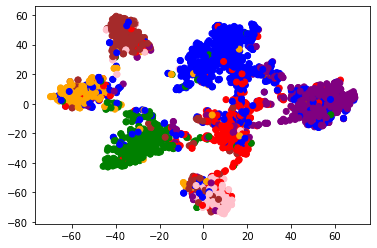

In [20]:
color_list = ["red", "orange", "green", "blue", "purple", "brown", "pink"]

loader = DataLoader(dataset, batch_size = 64, shuffle = True)
embs = []
colors = []

for batch in loader:
    emb, pred = model(batch)  # embs: our output embeddings
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim = 0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))  # TSNE high dim embedding into 2D plot
plt.scatter(xs, ys, color = colors)

## Learning unsupervised embeddings with graph autoencoders

### Link prediction task: graph completion (application)

Finally, GNNs fit nicely in the framework of other neural approaches, and can be used as part of autoencoder techniques, pretraining and multitask learning methods, etc. 

Here we explore the idea of neural network representations further by building a graph autoencoder which learns these representations in a completely unsupervised way. 

In contrast to the previous examples, we do not make use of the given node labels when training this representation. 

Instead, we encode the nodes in our network in a low-dimensional space in such a way that the embeddings can be decoded into a reconstruction of the original network. 

We use graph convolutional layers in the encoder. We can again use TensorBoardX here to visualize the training progress.

In [21]:
## graph with missing edges (use encoder and decoder)

class Encoder(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    writer.add_scalar("loss", loss.item(), epoch)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid("/tmp/citeseer", "Citeseer")  # same cide dataset as before. Now we are doing link prediction!!!
data = dataset[0]

channels = 16
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('CUDA availability:', torch.cuda.is_available())

## encoder: written by us; 
## decoder: default (inner product)

model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = pyg_utils.train_test_split_edges(data)  # IMPORTANT: doing split btw positive and negative edges
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    writer.add_scalar("AUC", auc, epoch)  # build in sklearn
    writer.add_scalar("AP", ap, epoch)  # build in sklearn
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Processing...
Done!
CUDA availability: False
Epoch: 010, AUC: 0.8688, AP: 0.8725
Epoch: 020, AUC: 0.8851, AP: 0.8904
Epoch: 030, AUC: 0.8880, AP: 0.8893
Epoch: 040, AUC: 0.8931, AP: 0.8962
Epoch: 050, AUC: 0.8959, AP: 0.9010
Epoch: 060, AUC: 0.8924, AP: 0.9017
Epoch: 070, AUC: 0.8888, AP: 0.9012
Epoch: 080, AUC: 0.8883, AP: 0.9007
Epoch: 090, AUC: 0.8865, AP: 0.9001
Epoch: 100, AUC: 0.8870, AP: 0.9008
Epoch: 110, AUC: 0.8870, AP: 0.9001
Epoch: 120, AUC: 0.8833, AP: 0.8971
Epoch: 130, AUC: 0.8823, AP: 0.8969
Epoch: 140, AUC: 0.8845, AP: 0.8975
Epoch: 150, AUC: 0.8849, AP: 0.8983
Epoch: 160, AUC: 0.8810, AP: 0.8966
Epoch: 170, AUC: 0.8841, AP: 0.8990
Epoch: 180, AUC: 0.8870, AP: 0.9009
Epoch: 190, AUC: 0.8850, AP: 0.8987
Epoch: 200, AUC: 0.8821, AP: 0.8970


Finally, we plot our embeddings (the output of the encoder) with TSNE. 

Note that we did not use any label information when training our encoder. 

Nodes with the same label are nevetheless close together in the embedding space. 

The model has learned the community structure without supervision!

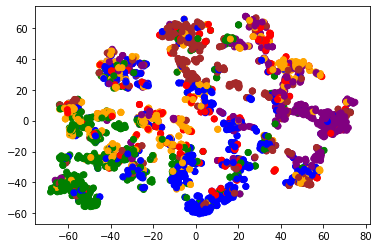

In [22]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))
plt.scatter(xs, ys, color = colors)
plt.show()  